References for code:

https://pytorch.org/docs/stable/data.html

https://stackoverflow.com/questions/69318733/intution-behind-weighted-random-sampler-in-pytorch

https://discuss.pytorch.org/t/proper-way-of-using-weightedrandomsampler/73147

https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/11

https://discuss.pytorch.org/t/how-to-prevent-overfitting/1902/3?u=smth

In [1]:
import pandas as pd
import numpy as np

import torch
import pathlib
import random
import cv2
import gc
import sys
import matplotlib.pyplot as plt
from collections import Counter

import solt as sl
import solt.transforms as slt
import sklearn.model_selection as ms
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import time
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device}')

Using cpu


In [2]:
base_path = "C:/Users/anush/OneDrive/Documents/Sem3/AI in Health Technology/Project/"

In [3]:
data = pd.read_csv("data_asDownloaded/train.csv")

In [4]:
data

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0
...,...,...
2925,e4a44f9158dc,0
2926,e4ae1ee6aada,0
2927,e4b0df29b96f,0
2928,e4c799738a19,0


In [5]:
dg_list = data['diagnosis'].to_list()
freq = Counter(dg_list)

In [6]:
freq

Counter({2: 808, 1: 300, 4: 234, 0: 1434, 3: 154})

In [7]:
class_counts = np.array([1434, 300, 808, 154, 234])
weight = 1. / class_counts
weight

array([0.00069735, 0.00333333, 0.00123762, 0.00649351, 0.0042735 ])

In [8]:
sample_weights = np.array(weight[data['diagnosis'].to_list()])
sample_weights

array([0.00123762, 0.00333333, 0.0042735 , ..., 0.00069735, 0.00069735,
       0.00069735])

In [9]:
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(data['diagnosis'].to_list()))

In [10]:
def get_train_transform():
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        normalize_transform()
    ])
    return train_transform

def get_valid_transform():
    valid_transform = transforms.Compose([
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        normalize_transform()
    ])
    return valid_transform


# Image normalization transforms.
def normalize_transform():
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    return normalize

In [11]:
def get_datasets():
    """
        Function to prepare the Datasets.
        :param pretrained: Boolean, True or False.
        Returns the training, validation and testing datasets along 
        with the class names.
    """
    dataset_train = datasets.ImageFolder(
        base_path+"/data/train", 
        transform=(get_train_transform())
    )
    dataset_val = datasets.ImageFolder(
        base_path+"/data/valid", 
        transform=(get_valid_transform())
    )
    dataset_test = datasets.ImageFolder(
        base_path+"/data/test", 
        transform=(get_valid_transform())
    )
    return dataset_train, dataset_val, dataset_test, dataset_train.classes


def get_data_loaders(dataset_train, dataset_valid, dataset_test, BATCH_SIZE=8):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    :param dataset_test: The test dataset.
    Returns the training, validation and testing data loaders.
    """
    train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, sampler=sampler)
    valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, valid_loader, test_loader

In [12]:
dataset_train, dataset_valid, dataset_test, dataset_classes = get_datasets(True)
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)

In [13]:
len(train_loader)

367

Model Definition and Training

In [14]:
model = models.efficientnet_b4(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

#For no finetuning-> Freezing model weights
for params in model.parameters():
    params.requires_grad = False
    
model.classifier = nn.Sequential(nn.Flatten(),
                                 nn.Linear(1792, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(256, 5))

In [15]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

18,008,909 total parameters.
460,293 training parameters.


In [17]:
# Optimizer:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Loss function:
criterion = nn.CrossEntropyLoss()

In [18]:
def train(model, trainloader, optimizer, criterion, epochNum):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    list_preds = []
    list_labels = []
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        list_preds.append(preds)
        list_labels.append(labels)
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
        
    torch.save(model, base_path+f"/efficientnet_b4_randomweight/model_checkpoint_{epochNum}.pt")
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    
    #for balanced accuracy
    list_true = []
    for i in range(len(list_labels)):
        for j in range(0, list_labels[i].shape[0]):
            list_true.append(int(list_labels[i][j]))

    list_pred = []
    for i in range(len(list_preds)):
        for j in range(0, list_preds[i].shape[0]):
            list_pred.append(int(list_preds[i][j]))
            
    balanced_acc = balanced_accuracy_score(list_true, list_pred)
    
    return epoch_loss, epoch_acc, balanced_acc

In [19]:
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    list_preds = []
    list_labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            list_preds.append(preds)
            list_labels.append(labels)
            
            
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    
    #for balanced accuracy
    list_true = []
    for i in range(len(list_labels)):
        for j in range(0, list_labels[i].shape[0]):
            list_true.append(int(list_labels[i][j]))

    list_pred = []
    for i in range(len(list_preds)):
        for j in range(0, list_preds[i].shape[0]):
            list_pred.append(int(list_preds[i][j]))
            
    balanced_acc = balanced_accuracy_score(list_true, list_pred)
    return epoch_loss, epoch_acc, balanced_acc

In [20]:
epochs = 20
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc, train_bacc = train(model, train_loader, optimizer, criterion, epoch)
    valid_epoch_loss, valid_epoch_acc, valid_bacc = validate(model, valid_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, training BACC: {train_bacc:.3f}")
    print(f"Valid loss: {valid_epoch_loss:.3f}, valid acc: {valid_epoch_acc:.3f}, valid BACC: {valid_bacc:.3f}")
    print('-'*50)
    time.sleep(5)

[INFO]: Epoch 1 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [58:35<00:00,  9.58s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:31<00:00,  3.30s/it]


Training loss: 0.773, training acc: 71.126, training BACC: 0.394
Valid loss: 0.646, valid acc: 75.956, valid BACC: 0.512
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [35:27<00:00,  5.80s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:01<00:00,  3.94s/it]


Training loss: 0.602, training acc: 77.304, training BACC: 0.516
Valid loss: 0.642, valid acc: 75.137, valid BACC: 0.468
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:48<00:00,  5.69s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:48<00:00,  3.66s/it]


Training loss: 0.568, training acc: 78.294, training BACC: 0.537
Valid loss: 0.641, valid acc: 77.869, valid BACC: 0.483
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:39<00:00,  5.67s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:50<00:00,  3.70s/it]


Training loss: 0.559, training acc: 79.625, training BACC: 0.579
Valid loss: 0.660, valid acc: 75.137, valid BACC: 0.488
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:39<00:00,  5.67s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:58<00:00,  3.87s/it]


Training loss: 0.575, training acc: 78.498, training BACC: 0.585
Valid loss: 0.655, valid acc: 74.044, valid BACC: 0.528
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [35:45<00:00,  5.85s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:58<00:00,  3.88s/it]


Training loss: 0.513, training acc: 81.263, training BACC: 0.622
Valid loss: 0.661, valid acc: 78.415, valid BACC: 0.530
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [35:44<00:00,  5.84s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:56<00:00,  3.83s/it]


Training loss: 0.502, training acc: 81.911, training BACC: 0.646
Valid loss: 0.636, valid acc: 76.776, valid BACC: 0.529
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [35:39<00:00,  5.83s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:53<00:00,  3.78s/it]


Training loss: 0.499, training acc: 81.365, training BACC: 0.628
Valid loss: 0.652, valid acc: 78.689, valid BACC: 0.518
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [35:39<00:00,  5.83s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:56<00:00,  3.83s/it]


Training loss: 0.491, training acc: 81.775, training BACC: 0.642
Valid loss: 0.648, valid acc: 77.869, valid BACC: 0.542
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [36:03<00:00,  5.90s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:54<00:00,  3.80s/it]


Training loss: 0.476, training acc: 81.877, training BACC: 0.643
Valid loss: 0.621, valid acc: 78.415, valid BACC: 0.561
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [35:33<00:00,  5.81s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:54<00:00,  3.80s/it]


Training loss: 0.477, training acc: 81.945, training BACC: 0.654
Valid loss: 0.608, valid acc: 78.962, valid BACC: 0.528
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [35:56<00:00,  5.88s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:51<00:00,  3.73s/it]


Training loss: 0.437, training acc: 83.823, training BACC: 0.693
Valid loss: 0.690, valid acc: 78.962, valid BACC: 0.523
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [35:42<00:00,  5.84s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:48<00:00,  3.66s/it]


Training loss: 0.441, training acc: 84.300, training BACC: 0.679
Valid loss: 0.649, valid acc: 78.689, valid BACC: 0.557
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:25<00:00,  5.63s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:56<00:00,  3.83s/it]


Training loss: 0.442, training acc: 83.823, training BACC: 0.671
Valid loss: 0.629, valid acc: 77.049, valid BACC: 0.577
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:36<00:00,  5.66s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:50<00:00,  3.71s/it]


Training loss: 0.445, training acc: 83.823, training BACC: 0.673
Valid loss: 0.670, valid acc: 76.503, valid BACC: 0.495
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:40<00:00,  5.67s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:48<00:00,  3.66s/it]


Training loss: 0.391, training acc: 85.870, training BACC: 0.688
Valid loss: 0.656, valid acc: 78.415, valid BACC: 0.572
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:45<00:00,  5.68s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:49<00:00,  3.69s/it]


Training loss: 0.430, training acc: 83.549, training BACC: 0.695
Valid loss: 0.656, valid acc: 78.689, valid BACC: 0.524
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:24<00:00,  5.62s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:46<00:00,  3.63s/it]


Training loss: 0.435, training acc: 83.379, training BACC: 0.681
Valid loss: 0.633, valid acc: 80.055, valid BACC: 0.578
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:13<00:00,  5.60s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:43<00:00,  3.56s/it]


Training loss: 0.411, training acc: 85.119, training BACC: 0.715
Valid loss: 0.680, valid acc: 78.142, valid BACC: 0.545
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [34:16<00:00,  5.60s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:42<00:00,  3.53s/it]


Training loss: 0.382, training acc: 86.519, training BACC: 0.728
Valid loss: 0.698, valid acc: 78.962, valid BACC: 0.528
--------------------------------------------------


In [21]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, pretrained):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
    plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(base_path + f"/outputs/accuracy_pretrained_{pretrained}.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
    plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(base_path + f"/outputs/loss_pretrained_{pretrained}.png")

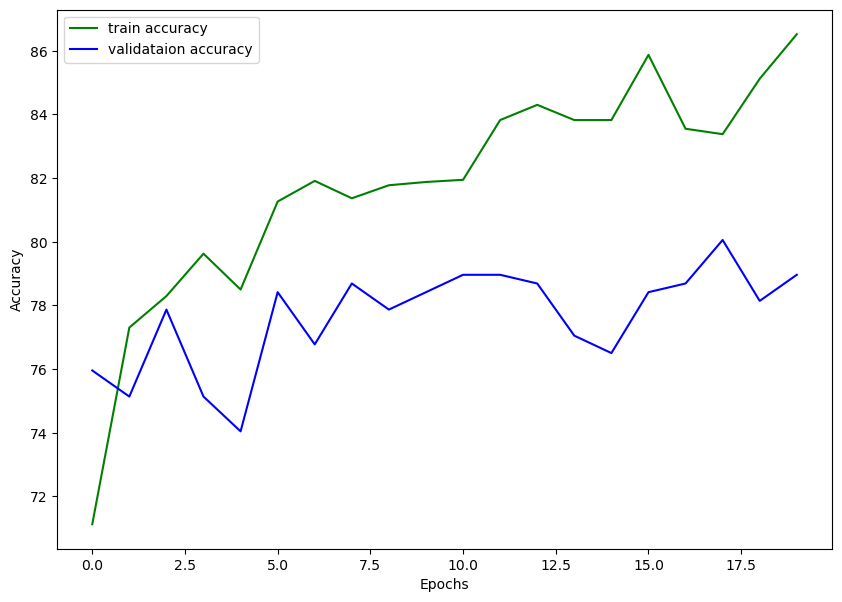

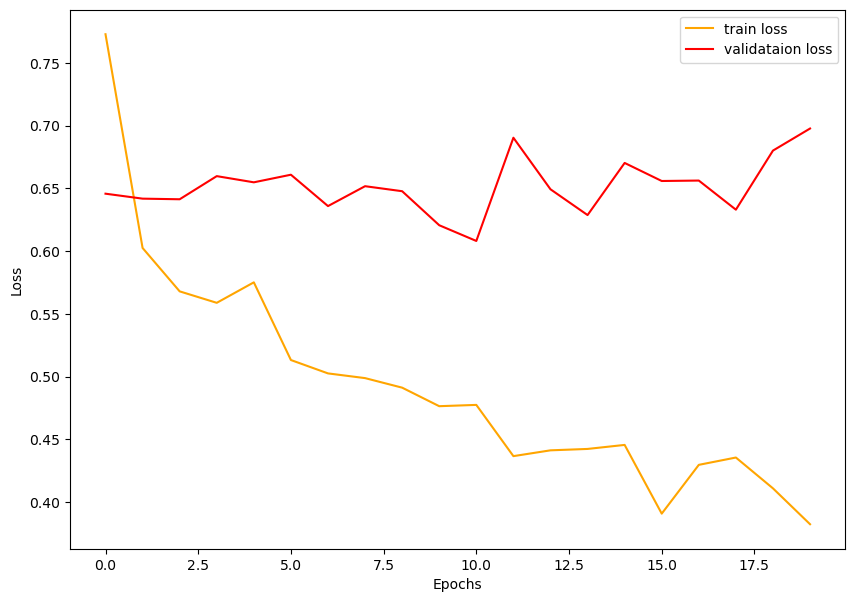

In [22]:
save_plots(train_acc, valid_acc, train_loss, valid_loss, "efficientnet_b4_randomweight")